In [3]:
from IPython.display import Image
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
%matplotlib inline

master_df = pd.read_pickle("master_5818")

In [4]:
from sklearn import pipeline,linear_model,tree\
,naive_bayes,model_selection,preprocessing,svm,metrics
from imblearn import over_sampling


In [5]:
#Taken from Class Lecture
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,xtrain, xtest, ytrain, ytest):
#     xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = metrics.confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
    cm=metrics.confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

**Baseline 87.2%**  
Since 87% of my restaurant inspections resulted in an "A", my first baseline will be a model that predicts all "A"s for all restaurants, all the time. This is obviously a "useless" model in that it doesnt tell us anything new, but it does give us a baseline that we should have to beat with any fancier models. Predicting just A's gets us to 87.2% accuracy, so any model has to beat that to be considered useful.

#### Clean Data

In [6]:
#split master_df into X and Y
master_y = master_df['grade']
master_x = master_df.drop(['grade','dba_master'],axis=1)
master_x['grade_date']=pd.to_datetime(master_x['grade_date'])
master_x_cats = master_x.copy()
# master_x['grade_date']=master_x['grade_date'].astype(int)
master_x =master_x.drop('grade_date',axis=1)

In [7]:
#Dummies for categoricals - date, cuisine, inspection type, boro

master_x_cats['year']=master_x_cats['grade_date'].dt.year
master_x_cats['month']=master_x_cats['grade_date'].dt.month
# master_x_cats['grade_date']=master_x_cats['grade_date'].astype(int)

for i in (['cuisine_description','inspection_type','boro']):
    master_x_cats = pd.concat([master_x_cats, pd.get_dummies\
                           (master_x_cats[i])], axis=1)
    master_x_cats = master_x_cats.drop(i,axis=1)

for i in (['month']):
    master_x_cats = pd.concat([master_x_cats, pd.get_dummies\
                           (master_x_cats[i],prefix=[i])], axis=1)
    master_x_cats = master_x_cats.drop(i,axis=1)
    
master_x_cats =master_x_cats.drop(['year','grade_date'],axis=1)
#create backup of master_y as "cats" version
master_y_cats = pd.DataFrame(master_y.copy())

This logistic regression pipeline will give us the best estimator for C value i.e. how much we should penalize overly complicated equations of fit.   

Note here that I am using x_cats and y_cats - these are larger dataframes than our original dataset, but are necessary to break out the many categorical columns we have. These still contain the same data as the original master_df, but have many more columns to allow logistic regression to run correctly. Most of these columns are "dummies".

In [8]:
x_train,x_test,y_train,y_test = \
model_selection.train_test_split(master_x_cats,master_y_cats)
sm = over_sampling.SMOTE(ratio='minority')
x_train_smote,y_train_smote = sm.fit_sample(x_train,y_train)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
x_train,x_test,y_train,y_test = \
model_selection.train_test_split(master_x_cats,master_y_cats,test_size=.1)


In [10]:
lr_coefs = linear_model.LogisticRegression(C=.3,class_weight=None)
lr_coefs.fit(x_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training Data Accuracy: 0.79
Test Data Accuracy:     0.65
[[10412  6788]
 [  110  2437]]


Precision:              0.26
Recall:                 0.96


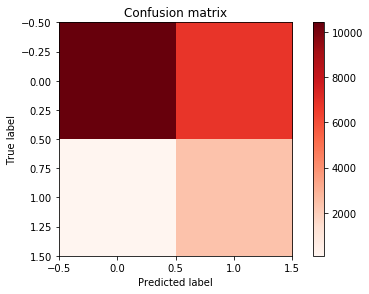

In [11]:
x_train,x_test,y_train,y_test = \
model_selection.train_test_split(master_x_cats,master_y_cats)

train_score(lr_coefs,x_train_smote,x_test,y_train_smote,y_test)

# TN  # FP
# FN  # TP

# True A             # False Predicted Non A
# False Predicted A  # True Predicted Non A

# def train_score(classifier,xtrain, xtest, ytrain, ytest):

[[17199     1]
 [ 2200   347]]


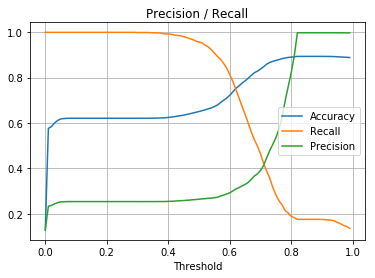

In [12]:
from sklearn import ensemble
#Cost Benefit RF
#Cost of Intervention is $100
#Cost of 2nd Inspection is $200
# -------------------------------------
#False Negatives cost $250 (missing a non-A, guessing A) - cost of inspection2/appeal
#True Positives save us $150 (guessing non-A, being right) - cost of inspection2 minus cost intervention
#False Positives cost us $100 (guessing non-A, being A) - cost of intervention
# -------------------------------------

y_proba = lr_coefs.predict_proba(x_test)
prec_log = {}
rec_log = {}
acc_log = {}
cost_ben_log = {}

for i in np.arange(0,1,.01):
    i = np.round(i,2)
    y_pred_high_precision = y_proba[:,1] >= i 
    y_pred_high_precision
    conf = metrics.confusion_matrix(y_test,y_pred_high_precision)
    
    ac_log = round(metrics.accuracy_score(y_test,y_pred_high_precision),4)
    pc_log = (conf[1, 1] / (conf[1, 1] + conf[0, 1]))
    rc_log = (conf[1, 1] / (conf[1, 1] + conf[1, 0]))
    
    acc_log[i]= ac_log
    prec_log[i]= pc_log
    rec_log[i] = rc_log
#     cost_ben_log[i] = ((250 * (1-rc_log)) + (100*(1-pc_log)) - (150*pc_log))
    #
    cost_ben_log[i] = ((250 * conf[1, 0]) + (100*conf[0, 1]) - ((150*conf[1, 1])))/len(y_test)
#     Expected_Value = #TPs(2160) - #FNs(2900) -#FPs(750)

print(conf)
plt.plot(acc_log.keys(),acc_log.values(),label="Accuracy")
plt.plot(rec_log.keys(),rec_log.values(),label="Recall")
plt.plot(prec_log.keys(),prec_log.values(),label="Precision")
# plt.plot(cost_ben.keys(),cost_ben.values(),label="Cost Benefit")
plt.legend()
plt.grid()
plt.xlabel("Threshold")
plt.title('Precision / Recall');

# metrics.
# TN  # FP
# FN  # TP

In [13]:
for i in np.arange(.55,.7,.01):
    i = np.round(i,4)
    print(i,cost_ben_log[i])

0.55 16.977262368967438
0.56 16.815212437332253
0.57 16.273357978427104
0.58 15.96951435661113
0.59 15.75682382133995
0.6 15.660606674431559
0.61 15.33144275079759
0.62 15.169392819162404
0.63 15.478300501341977
0.64 15.685926976249556
0.65 16.09611586570112
0.66 16.430343849698687
0.67 16.65316250569707
0.68 16.815212437332253
0.69 17.220337266420216


15.169392819162404


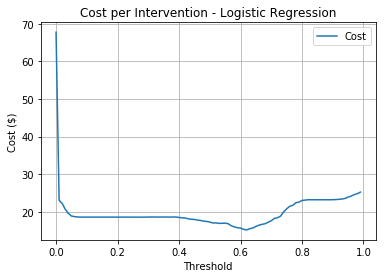

In [14]:
print(min(cost_ben_log.values()))

plt.plot(cost_ben_log.keys(),cost_ben_log.values(),label="Cost")
plt.legend();
plt.xlabel("Threshold")
plt.ylabel("Cost ($)")
plt.grid()
plt.title('Cost per Intervention - Logistic Regression')
plt.savefig("Cost_PerIntervention_Logistic");

In [15]:
for i in np.arange(0.01,1.01,0.05):
    y_pred_high_precision = y_proba[:,1] >= i 
    y_pred_high_precision
    conf = metrics.confusion_matrix(y_test,y_pred_high_precision)
    print(f"Threshold at {round(i,2)} \n")
    print(conf)
    print("")
    test_thresh = np.round(i,2)
    print(f"Threshold: {test_thresh}")
    print(f"Accuracy: {acc_log[test_thresh]}")
    print(f"Precision: {prec_log[test_thresh]}")
    print(f"Recall: {rec_log[test_thresh]}")
    print(f"Cost-Benefit: {cost_ben_log[test_thresh]}" )
    print("********************************")
    
#         cost_ben_log[i] = ((250 * (1-rc_log)) + (100*(1-pc_log)) - (150*pc_log))*100



Threshold at 0.01 

[[8834 8366]
 [   1 2546]]

Threshold: 0.01
Accuracy: 0.5763
Precision: 0.23332111436950145
Recall: 0.9996073812328229
Cost-Benefit: 23.038942624196082
********************************
Threshold at 0.06 

[[9689 7511]
 [   1 2546]]

Threshold: 0.06
Accuracy: 0.6196
Precision: 0.2531570050710948
Recall: 0.9996073812328229
Cost-Benefit: 18.70917101331848
********************************
Threshold at 0.11 

[[9716 7484]
 [   1 2546]]

Threshold: 0.11
Accuracy: 0.621
Precision: 0.25383848454636093
Recall: 0.9996073812328229
Cost-Benefit: 18.572441383501292
********************************
Threshold at 0.16 

[[9716 7484]
 [   1 2546]]

Threshold: 0.16
Accuracy: 0.621
Precision: 0.25383848454636093
Recall: 0.9996073812328229
Cost-Benefit: 18.572441383501292
********************************
Threshold at 0.21 

[[9716 7484]
 [   1 2546]]

Threshold: 0.21
Accuracy: 0.621
Precision: 0.25383848454636093
Recall: 0.9996073812328229
Cost-Benefit: 18.572441383501292
*************

##### Random Forest

In [16]:
from sklearn import ensemble
from imblearn import over_sampling

In [17]:
kfold = model_selection.StratifiedKFold(n_splits = 5)

In [18]:
#Now trying with oversampling

x_train,x_test,y_train,y_test = \
model_selection.train_test_split(master_x_cats,master_y_cats)
sm = over_sampling.SMOTE(ratio=1)
x_train_smote,y_train_smote = sm.fit_sample(x_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
rf_best = ensemble.RandomForestClassifier\
(class_weight=None,max_features='auto')

x_train,x_test,y_train,y_test = \
model_selection.train_test_split(master_x_cats,master_y_cats)
sm = over_sampling.SMOTE(ratio=1)
x_train_smote,y_train_smote = sm.fit_sample(x_train,y_train)

rf_best.fit(x_train_smote,y_train_smote)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

[[17134   120]
 [ 2179   314]]


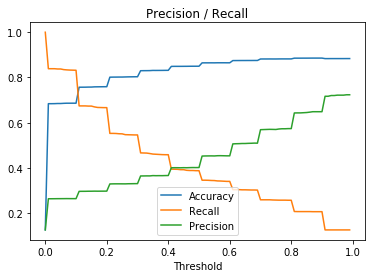

In [20]:
#Cost Benefit RF
#Cost of Intervention is $100
#Cost of 2nd Inspection is $200
# -------------------------------------
#False Negatives cost $500 (missing a non-A, guessing A) - cost of inspection2/appeal
#True Positives save us $400 (guessing non-A, being right) - action saves us cost of inspection2 - cost intervention
#False Positives cost us $100 (guessing non-A, being A) - wasted intervention
#     cost_ben_log[i] = (500 * (1-rc_log)) + (100*(1-pc_log)) - (400*pc_log)
# -------------------------------------

y_proba = rf_best.predict_proba(x_test)
prec = {}
rec = {}
acc = {}
cost_ben = {}

for i in np.arange(0,1,.01):
    y_pred_high_precision = y_proba[:,1] >= i 
    y_pred_high_precision
    conf = metrics.confusion_matrix(y_test,y_pred_high_precision)
    
    ac = round(metrics.accuracy_score(y_test,y_pred_high_precision),4)
    pc = (conf[1, 1] / (conf[1, 1] + conf[0, 1]))
    rc = (conf[1, 1] / (conf[1, 1] + conf[1, 0]))
    
    acc[i]= ac
    prec[i]= pc
    rec[i] = rc
#     cost_ben[i] = (500 * (1-rc)) + (100*(1-pc)) - (400*pc)
#     cost_ben[i]  = ((250 * (1-rc)) + (100*(1-pc)) - (150*pc))
    cost_ben[i] = ((250 * conf[1, 0]) + (100*conf[0, 1]) - ((150*conf[1, 1])))/len(y_test)
    

print(conf)
plt.plot(acc.keys(),acc.values(),label="Accuracy")
plt.plot(rec.keys(),rec.values(),label="Recall")
plt.plot(prec.keys(),prec.values(),label="Precision")
# plt.plot(cost_ben.keys(),cost_ben.values(),label="Cost Benefit")
plt.legend();
plt.xlabel("Threshold")
plt.title('Precision / Recall');

# metrics.
# TN  # FP
# FN  # TP

17.671038638780573


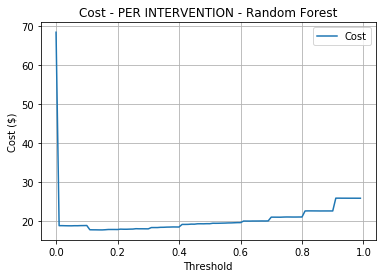

In [21]:
print(min(cost_ben.values()))


plt.plot(cost_ben.keys(),cost_ben.values(),label="Cost")
plt.legend();
plt.xlabel("Threshold")
plt.ylabel("Cost ($)")
plt.grid()
plt.savefig("Cost_perint_RF")
plt.title('Cost - PER INTERVENTION - Random Forest');

In [22]:
for i in np.arange(0.01,0.5,0.05):
    y_pred_high_precision = y_proba[:,1] >= i 
    y_pred_high_precision
    conf = metrics.confusion_matrix(y_test,y_pred_high_precision)
    print(conf)
    print("")
    test_thresh = round(i,2)
    print(f"Threshold: {test_thresh}")
    print(f"Accuracy: {acc[test_thresh]}")
    print(f"Precision: {prec[test_thresh]}")
    print(f"Recall: {rec[test_thresh]}")
    print(f"Cost-Benefit: {cost_ben[test_thresh]}" )
    print("********************************")



[[11417  5837]
 [  402  2091]]

Threshold: 0.01
Accuracy: 0.6841
Precision: 0.2637487386478305
Recall: 0.838748495788207
Cost-Benefit: 18.764875677318074
********************************
[[11460  5794]
 [  413  2080]]

Threshold: 0.06
Accuracy: 0.6857
Precision: 0.26425396825396824
Recall: 0.8347372643401524
Cost-Benefit: 18.749683496227274
********************************
[[13265  3989]
 [  812  1681]]

Threshold: 0.11
Accuracy: 0.7569
Precision: 0.2964726631393298
Recall: 0.6742880064179703
Cost-Benefit: 17.71155112168937
********************************
[[13308  3946]
 [  824  1669]]

Threshold: 0.16
Accuracy: 0.7585
Precision: 0.29736467236467234
Recall: 0.6698756518251103
Cost-Benefit: 17.71661518205297
********************************
[[14446  2808]
 [ 1115  1378]]

Threshold: 0.21
Accuracy: 0.8013
Precision: 0.32919254658385094
Recall: 0.5527476935419173
Cost-Benefit: 17.868536992960955
********************************
[[14479  2775]
 [ 1129  1364]]

Threshold: 0.26
Accuracy: 0.

KeyError: 0.41

In [23]:
for test_thresh in np.arange(0.01,0.2,0.05):
    test_thresh = round(test_thresh,2)
    print(f"Threshold: {test_thresh}")
    print(f"Accuracy: {acc[test_thresh]}")
    print(f"Precision: {prec[test_thresh]}")
    print(f"Recall: {rec[test_thresh]}")
    print(f"Cost-Benefit: {cost_ben[test_thresh]}" )
    print("********************************")

Threshold: 0.01
Accuracy: 0.6799
Precision: 0.26289371313841137
Recall: 0.8241542092840283
Cost-Benefit: 19.491568339494606
********************************
Threshold: 0.06
Accuracy: 0.6808
Precision: 0.2623199393479909
Recall: 0.8166797797010228
Cost-Benefit: 19.69413075403859
********************************
Threshold: 0.11
Accuracy: 0.7494
Precision: 0.2908047974969581
Recall: 0.6581431943351692
Cost-Benefit: 18.954777940953058
********************************
Threshold: 0.16
Accuracy: 0.7505
Precision: 0.2910460837567899
Recall: 0.6534225019669552
Cost-Benefit: 19.02567478604345
********************************


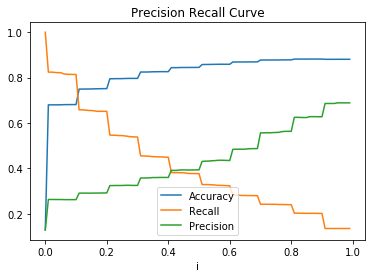

In [24]:
plt.plot(acc.keys(),acc.values(),label="Accuracy")
plt.plot(rec.keys(),rec.values(),label="Recall")
plt.plot(prec.keys(),prec.values(),label="Precision")
plt.legend();
plt.xlabel("i")
plt.title('Precision Recall Curve');

In [25]:
from sklearn.metrics import precision_recall_curve

p,r,t=precision_recall_curve(y_test,y_score)

# adding last threshold of '1' to threshold list
t=np.vstack([t.reshape([-1,1]),1])

# plt.plot(p,t)
# plt.plot(r,t);
plt.plot(t,p,label="Precision")
plt.plot(t,r,label="Recall")
plt.legend();
plt.title('Precision Recall Curve');



NameError: name 'y_score' is not defined